In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import os
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
from glob import glob

In [3]:
root_dir = "/clusterfs/nilah/pooja"
fig_dir = f"{root_dir}/CellTypeSpecificAccessibilityPrediction/figures"

## Loeb et al data

In [29]:
predict_peak_bed_dir = "/clusterfs/nilah/pooja/kidney_data/CellTypeSpecificPeakClusters_ArchR_clust11/model_predictions"
peak_types = natsorted([p.split("/")[-1] for p 
                        in glob(f"{predict_peak_bed_dir}/cluster*")])
chrs = list(range(1, 23))
cell_types = np.array(["Immune","Str","Pod","CD","CFH","Tcell","End","DT","PT","LOH"])

In [30]:
peak_bed_preds = {}
for pt in peak_types:
    for chr in chrs:
        preds = h5py.File(f"{predict_peak_bed_dir}/{pt}/chr{chr}/predict.h5", "r")
        preds_df = pd.DataFrame(np.squeeze(preds["preds"][:,:,:]), columns=[f"{ct}_pred" for ct in cell_types])  
        preds_df["chrom"] = preds["chrom"][:].astype(str)
        preds_df["start"] = preds["start"][:]
        preds_df["end"] = preds["end"][:]
    
        if chr == 1:
            peak_bed_preds[pt] = preds_df
        else:
            peak_bed_preds[pt] = pd.concat([peak_bed_preds[pt], preds_df])
    peak_bed_preds[pt]["name"] = [f"{pt}_{i}" for i in range(peak_bed_preds[pt].shape[0])]

In [31]:
for pt in peak_types:
    for ct in cell_types:
        peak_bed_preds[pt][f"{ct}_target"] = pd.read_csv(f"{predict_peak_bed_dir}/{pt}/{ct}_target_signal.out", 
                                                         sep="\t",
                                                         names=["name", "size", "covered", 
                                                                "sum", "mean0", "mean"])["sum"].values

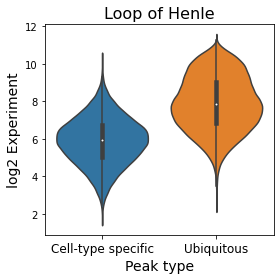

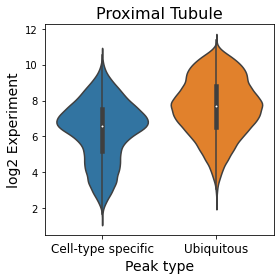

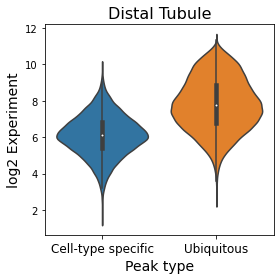

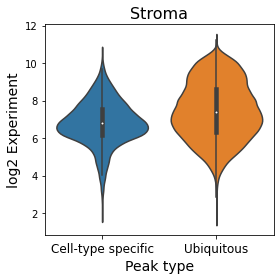

In [38]:
# histograms
cell_type_peak_set_mapping = {"LOH": ["cluster4_DistalNephron", "cluster3_Ubiquitous"],
                            "PT": ["cluster11_PT", "cluster3_Ubiquitous"],
                              "DT": ["cluster4_DistalNephron", "cluster3_Ubiquitous"],
                              "Str": ["cluster9_Stroma", "cluster3_Ubiquitous"]}
cell_type_labels = ["Loop of Henle", "Proximal Tubule", "Distal Tubule", "Stroma"]
peak_type_labels = ["Cell-type specific", "Ubiquitous"]

for ti, (ct, peak_sets) in enumerate(cell_type_peak_set_mapping.items()):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    cell_type_data = []
    for i, peak_set in enumerate(peak_sets):
        # subset and flatten
        test_targets_ti_flat = peak_bed_preds[peak_set][f"{ct}_target"].values.flatten().astype('float32')

        # take log2
        test_targets_ti_log = np.log2(test_targets_ti_flat + 1)
        cell_type_data.append(test_targets_ti_log)
        
    sns.violinplot(data=cell_type_data, 
                   orient="v", scale="width", ax=ax)
    ax.set_ylabel("log2 Experiment", fontsize=14)
    ax.set_xlabel("Peak type", fontsize=14)
    ax.set_xticklabels(peak_type_labels, fontsize=12)
    ax.set_title(cell_type_labels[ti], fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/supp_figs/{ct}_peak_heights.pdf", dpi=1200)

Peak height matched performance

LOH cluster3_Ubiquitous 0 1
LOH cluster3_Ubiquitous 1 0
LOH cluster3_Ubiquitous 2 0
LOH cluster3_Ubiquitous 3 0
LOH cluster3_Ubiquitous 4 0
LOH cluster3_Ubiquitous 5 0
LOH cluster3_Ubiquitous 6 0
LOH cluster3_Ubiquitous 7 0
PT cluster3_Ubiquitous 0 0
PT cluster3_Ubiquitous 1 0
PT cluster3_Ubiquitous 2 0
PT cluster3_Ubiquitous 3 0
DT cluster3_Ubiquitous 0 0
DT cluster3_Ubiquitous 1 0
DT cluster3_Ubiquitous 2 0
DT cluster3_Ubiquitous 3 0
DT cluster3_Ubiquitous 4 0
DT cluster3_Ubiquitous 5 0
DT cluster3_Ubiquitous 6 0
DT cluster3_Ubiquitous 7 0
DT cluster3_Ubiquitous 8 0
Str cluster3_Ubiquitous 0 0
Str cluster3_Ubiquitous 1 0
Str cluster3_Ubiquitous 2 0
Cell-type specific 0.37728518297329683
Ubiquitous 0.48282481179761927


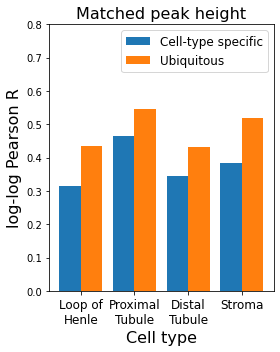

In [36]:
# match peak heights
# make bar plots
bins = np.arange(2.5, 10.5, .5)
cell_type_peak_set_mapping = {"LOH": ["cluster4_DistalNephron", "cluster3_Ubiquitous"],
                            "PT": ["cluster11_PT", "cluster3_Ubiquitous"],
                              "DT": ["cluster4_DistalNephron", "cluster3_Ubiquitous"],
                              "Str": ["cluster9_Stroma", "cluster3_Ubiquitous"]}
cell_type_labels = ["Loop of\nHenle", "Proximal\nTubule", "Distal\nTubule", "Stroma"]
peak_type_labels = ["Cell-type specific", "Ubiquitous"]
corrs = []
for ti, (ct, peak_sets) in enumerate(cell_type_peak_set_mapping.items()):
    
    
    ct_corrs = []
    for i, peak_set in enumerate(peak_sets):
        # subset and flatten
        test_targets_ti_flat = peak_bed_preds[peak_set][f"{ct}_target"].values.flatten(
          ).astype('float32')
        test_preds_ti_flat = peak_bed_preds[peak_set][f"{ct}_pred"].values.flatten().astype(
              'float32')

        # take log2
        test_targets_ti_log = np.log2(test_targets_ti_flat + 1)
        test_preds_ti_log = np.log2(test_preds_ti_flat + 1)
        
        if i == 0:
            bin_counts, bins = np.histogram(test_targets_ti_log, 
                                            bins=bins)

        bin_assignments = np.digitize(test_targets_ti_log, bins) - 1
        sample_inds = []
        for bin_i, bin_count in enumerate(bin_counts):
            bin_inds = np.where(bin_assignments == bin_i)[0]
            try:
                sampled_bin_inds = np.random.choice(bin_inds, bin_count, replace=False)
            except:
                if len(bin_inds) > 0:
                    print(ct, peak_set, bin_i, 0)
                    sampled_bin_inds = np.random.choice(bin_inds, bin_count, replace=True)
                else:
                    print(ct, peak_set, bin_i, 1)
                    sampled_bin_inds = np.array([])
            sample_inds.extend(sampled_bin_inds)
        sample_inds = np.array(sample_inds)
        
        ct_corrs.append(pearsonr(test_targets_ti_log[sample_inds], test_preds_ti_log[sample_inds])[0])
    corrs.append(ct_corrs)
    
cmap=plt.get_cmap("tab10")
width = 0.4
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

for i, peak_type in enumerate(peak_type_labels):
    print(peak_type, np.mean([corrs[j][i] for j in range(len(corrs))]))
    ax.bar(np.arange(len(cell_type_labels))+i*width, [corrs[j][i] for j in range(len(corrs))], width,
           label=peak_type, color=cmap(i))
    
ax.set_xticks(np.arange(len(cell_type_labels))+0.5*width)
l = ax.set_xticklabels(cell_type_labels, fontsize=12)
ax.set_xlabel("Cell type", fontsize=16)
ax.set_ylabel("log-log Pearson R", fontsize=16)
ax.set_ylim(0, 0.8)
plt.legend(loc="upper right", fontsize=12)
plt.title("Matched peak height", fontsize=16)
plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_reference_accuracy_peak_height_matched.pdf", dpi=1200)

## Calderon et al data

In [39]:
immune_atlas_dir = "/clusterfs/nilah/pooja/immune_atlas"
predict_peak_bed_dir = f"{immune_atlas_dir}/CellTypeSpecificPeakClusters/model_predictions"
peak_types = natsorted([p.split("/")[-1] for p 
                        in glob(f"{predict_peak_bed_dir}/cluster*_float32")])
peak_types = [p.split('_float32')[0] for p in peak_types]

targets = pd.read_csv(f"{immune_atlas_dir}/targets.txt", sep="\t")
cell_types = targets["identifier"].values

In [40]:
peak_bed_preds = {}
for pt in peak_types:
    preds = h5py.File(f"{predict_peak_bed_dir}/{pt}_float32/predict.h5", "r")
    preds_df = pd.DataFrame(np.nan_to_num(np.squeeze(preds["preds"][:,:,:])).astype("float64"), 
                            columns=[f"{ct}_pred" for ct in cell_types])  
    preds_df["chrom"] = preds["chrom"][:].astype(str)
    preds_df["start"] = preds["start"][:]
    preds_df["end"] = preds["end"][:]
    preds_df["name"] = [f"{pt}_{i}" for i in range(preds_df.shape[0])]
    peak_bed_preds[pt] = preds_df

In [41]:
for pt in peak_types:
    for ct in cell_types:
        temp = pd.read_csv(f"{predict_peak_bed_dir}/{pt}/{ct}_target_signal.out", 
                                                         sep="\t",
                                                         names=["name", "size", "covered", "sum", "mean0", "mean"])

        temp["name"] = temp["name"].apply(lambda x: int(x.split("_")[-1]))
        temp = temp.sort_values("name")
        peak_bed_preds[pt][f"{ct}_target"] = temp["sum"].values

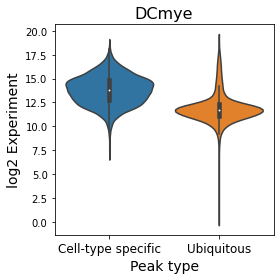

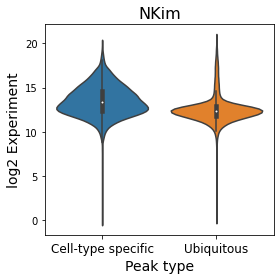

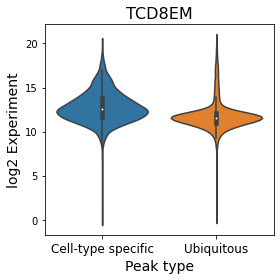

In [42]:
# histograms
cell_type_peak_set_mapping = {"DCmye": ["cluster_myeloid_resting", "cluster_open"],
                              "NKim": ["cluster_nk_resting", "cluster_open"],
                              "TCD8EM": ["cluster_T_resting", "cluster_open"],}

cell_type_labels = list(cell_type_peak_set_mapping.keys())
peak_type_labels = ['Cell-type specific', 'Ubiquitous']


for ti, (ct, peak_sets) in enumerate(cell_type_peak_set_mapping.items()):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    cell_type_data = []
    for i, peak_set in enumerate(peak_sets):
        # subset and flatten
        test_targets_ti_flat = peak_bed_preds[peak_set][f"{ct}_target"].values.flatten(
          ).astype('float32')

        # take log2
        test_targets_ti_log = np.log2(test_targets_ti_flat + 1)
        cell_type_data.append(test_targets_ti_log)
        
    sns.violinplot(data=cell_type_data, 
                   orient="v", scale="width", ax=ax)
    ax.set_ylabel("log2 Experiment", fontsize=14)
    ax.set_xlabel("Peak type", fontsize=14)
    ax.set_xticklabels(peak_type_labels, fontsize=12)
    ax.set_title(cell_type_labels[ti], fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/supp_figs/{ct}_peak_heights.pdf", dpi=1200)
